# Equivalence Checking of Parameterized Quantum Circuits

[![Download Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/advanced/mindspore_equivalence_checking_of_PQC.ipynb)&emsp;
[![Download Code](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/master/mindquantum/en/advanced/mindspore_equivalence_checking_of_PQC.py)&emsp;
[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindquantum/docs/source_en/advanced/equivalence_checking_of_PQC.ipynb)

## Introduction

Before running on a quantum device, a parameterized quantum circuit needs to be compiled into a new circuit consisting of the set of quantum gates supported by the device. Therefore, it is necessary to check the equivalence of the two circuits before and after compilation. In the paper Equivalence Checking of Parameterized Quantum Circuits, a method for checking the equivalence of parameterized quantum circuits based on ZX calculus is proposed. This tutorial attempts to reproduce the method in the MindSpore Quantum architecture.

Paper link: https://doi.org/10.1145/3566097.3567932

In [1]:
# import libraries
from mindquantum.core.circuit import Circuit
import numpy as np
from mindquantum.core.gates import H, CNOT, RX, RZ
from mindquantum.core.circuit import dagger

## Step 1

Prepare the quantum circuits.

Take the TwoLocal-Circular circuit in the Qiskit circuits library as an example. The TwoLocal circuit is a parameterized circuit composed of alternating rotation layers and entanglement layers. Rotation layer consists of single qubit gates acting on all qubits. Entanglement layer consists of double qubit gates to entangle qubits according to the entanglement strategy.

Construct a TwoLocal-Circular circuit acting on 127-bit qubits, consisting of three sets of rotation layers and entanglement layers alternately, containing a total of 508 parameters. The rotation layer is [RX](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RX.html) gates acting on each qubit. The entanglement layer is a [CNOT](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.CNOTGate.html) gate on the first qubit controlled by the last qubit and [CNOT](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.CNOTGate.html) gates on the next qubit controlled by the previous qubit.

In [2]:
# ansatz = rotation layer + entanglement layer
def build_ansatz(n_qubits, depth):
    circ = Circuit()    # initialize a quantum circuit

    for i in range(depth):
        for j in range(n_qubits):
            circ += RX(f'theta{i*n_qubits+j}').on(j)    # RX gate on each qubit
        # CNOT gate on the first qubit controlled by the last qubit
        circ += CNOT.on(0, n_qubits-1)
        for j in range(n_qubits-1):
            # CNOT gate on the next qubit controlled by the previous qubit
            circ += CNOT.on(j+1, j)

    for j in range(n_qubits):
        circ += RX(f'theta{depth*n_qubits+j}').on(j)    # RX gate on each qubit

    return circ

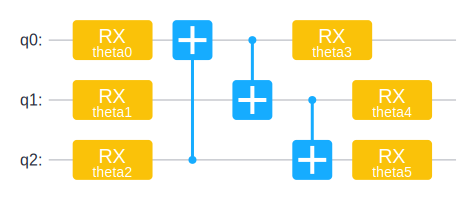

In [3]:
# example ansatz: 3 qubits and 1 layer
build_ansatz(3, 1).svg()

In [4]:
# initial circuit: 127 qubits and 3 layer
n_qubits = 127
depth = 3
circ1 = build_ansatz(n_qubits, depth)
circ1.summary()

                                       Circuit Summary                                       
╭───────────────────────┬───────────────────────────────────────────────────────────────────╮
│ Info                  │ value                                                             │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Number of qubit       │ 127                                                               │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Total number of gate  │ 889                                                               │
│ Barrier               │ 0                                                                 │
│ Noise Channel         │ 0                                                                 │
│ Measurement           │ 0                                                                 │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Parameter gate        │ 508                                                               │
│ 508 ansatz parameters │ theta0, theta1, theta2, theta3, theta4, theta5, theta6, theta7,   │
│                       │ theta8, theta9...                                                 │
╰───────────────────────┴───────────────────────────────────────────────────────────────────╯

Then do the compilation.

Suppose the set of quantum gates before compilation is: [H](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html), [CNOT](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.CNOTGate.html), [RZ](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RZ.html), [RX](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html). The compiled set of quantum gates is: [H](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RX.html), [CNOT](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.CNOTGate.html), [RZ](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RZ.html). The compilation rule is that the [H](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html), [CNOT](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.CNOTGate.html), and [RZ](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RZ.html) gates remain unchanged, and the [RX](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RX.html) gates are compiled into a combination of [H](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html), [RZ](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RZ.html), [H](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html).

In [5]:
def compile_circuit(circ):
    circ_compiled = Circuit()

    for gate in circ:    # traverse the gates in the initial circuit
        # the H, CNOT, and RZ gates remain unchanged
        if gate.name == 'H' or gate.name == 'CNOT' or gate.name == 'RZ':
            circ_compiled += gate
        # the RX gates are compiled into a combination of H*RZ*H
        elif gate.name == 'RX':
            circ_compiled += H.on(gate.obj_qubits)
            circ_compiled += RZ(gate.coeff).on(gate.obj_qubits)
            circ_compiled += H.on(gate.obj_qubits)

    return circ_compiled

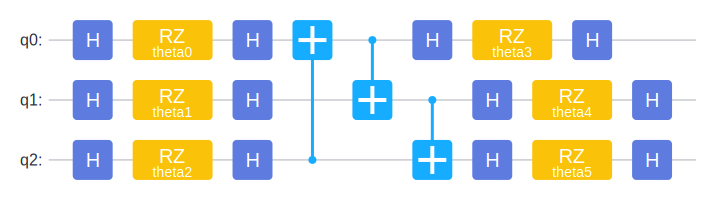

In [6]:
# Example of a line generated by compiling a layer of ansatz lines and we can see that all RX gates have changed according to the compilation rules
compile_circuit(build_ansatz(3, 1)).svg()

In [7]:
# compile initial circuit
circ2 = compile_circuit(circ1)
circ2.summary()    # summary compilation circuit

                                       Circuit Summary                                       
╭───────────────────────┬───────────────────────────────────────────────────────────────────╮
│ Info                  │ value                                                             │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Number of qubit       │ 127                                                               │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Total number of gate  │ 1905                                                              │
│ Barrier               │ 0                                                                 │
│ Noise Channel         │ 0                                                                 │
│ Measurement           │ 0                                                                 │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Parameter gate        │ 508                                                               │
│ 508 ansatz parameters │ theta0, theta1, theta2, theta3, theta4, theta5, theta6, theta7,   │
│                       │ theta8, theta9...                                                 │
╰───────────────────────┴───────────────────────────────────────────────────────────────────╯

Finally, construct the complete cicuit.

According to the reversibility of the quantum circuit, if the two circuits are equivalent, then applying one circuit and the reversion of the other circuit, the final quantum state is equivalent to the state before the application. Thus, the complete quantum circuit consists of the compiled circuit and the reversion of the initial circuit.

In [8]:
# complete circuit
circ1_inv = dagger(circ1)    # dagger() reverse the circuit
# complete circuit = reversion of initial circuit + circuit after compilation
circ_all = circ1_inv + circ2
circ_all.summary()    # summary complete circuit

                                       Circuit Summary                                       
╭───────────────────────┬───────────────────────────────────────────────────────────────────╮
│ Info                  │ value                                                             │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Number of qubit       │ 127                                                               │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Total number of gate  │ 2794                                                              │
│ Barrier               │ 0                                                                 │
│ Noise Channel         │ 0                                                                 │
│ Measurement           │ 0                                                                 │
├───────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Parameter gate        │ 1016                                                              │
│ 508 ansatz parameters │ theta507, theta506, theta505, theta504, theta503, theta502,       │
│                       │ theta501, theta500, theta499, theta498...                         │
╰───────────────────────┴───────────────────────────────────────────────────────────────────╯

## Setp 2

Draw the complete circuit into ZX diagram.

The equivalence checking of parameterized quantum circuits is based on the ZX calculus. Then the quantum circuits need to be converted into ZX diagrams.

The quantum gate is the vertex in the ZX diagram, divided into 3 colors. The [H](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.HGate.html) gate is represented as a yellow vertex, the [RX](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RX.html) gate is a red vertex with parameters, and the [RZ](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.RZ.html) gate is a green vertex with parameters. The target qubit of the [CNOT](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.CNOTGate.html) gate is a red vertex, and the control qubit is a green vertex, which two are neighbors. The vertices of two adjacent quantum gates on the same qubit are neighbors to each other.

Start by defining the vertex class and graph class.

In [9]:
class Vertex:
    def __init__(self, name, color, qubit, neighbor, phase=0.0):
        self.name = name    # the number of the vertex
        self.color = color    # the color of the vertex
        self.phase = phase   # the parameter of the vertex
        self.qubit = qubit     # the qubit of the vertex
        self.neighbor = neighbor    # the neighbor of the vertex

In [10]:
# graph class
class Graph:
    def __init__(self):
        self.vertices = {}
        # count: the total number of vertices
        # which only increases but does not decrease
        # count is also used to name new vertices
        self.count = 0

    # add an edge from the start to the end
    def add_edge(self, from_vertex, to_vertex):
        self.vertices[from_vertex].neighbor.append(to_vertex)

    # add vertex
    def add_vertex(self, color, qubit, neighbor, phase=0.0):
        name = self.count
        self.count += 1
        # add edges from the current vertex to its neighbors
        self.vertices[name] = Vertex(name, color, qubit, neighbor, phase)
        for v in neighbor:    # add edges from its neighbors to it
            self.add_edge(v, name)

    def print(self):
        print("==================graph message==================")
        for v in self.vertices.values():
            print(v.name, '\t', v.neighbor, '\t', v.color, '\t', v.phase)
        print('\n')

    # clear the loops produced during adding or deleting
    # there is no loop in ZX-diagram(loop which made of a single edge)
    def clear(self):
        for v in self.vertices.values():
            while v.name in v.neighbor:
                # remove the vertex from its own neighbors
                self.vertices[v.name].neighbor.remove(v.name)

    # delete vertex
    def delete_vertex(self, name):
        for v in self.vertices.values():
            while name in v.neighbor:
                # delete edges whose end is the current vertex
                self.vertices[v.name].neighbor.remove(name)
        # delete edges whose start is the current vertex
        self.vertices.pop(name)

    # if two circuits are equivalent
    def equiv(self):
        # if equivalent, after simplification, there is no vertex
        if not self.vertices:
            print("Equivalent!")
        else:
            print("Not sure!")

Then draw the quantum circuit into a ZX diagram.

Traverse all the quantum gates in the circuit and plot them as vertices in the ZX diagram. If there is no gate on the current qubit, the current quantum gate has no neighbors. If there has at least one quantum gate on the current qubit, the current quantum gate and the last quantum gate on the qubit are neighbors. The [CNOT](https://www.mindspore.cn/mindquantum/docs/en/master/core/gates/mindquantum.core.gates.CNOTGate.html) gate adds a neighbor relationship between the control qubit and the target qubit.

In [11]:
def draw_graph(circ):
    g = Graph()
    # last_name saves the last vertex on each qubit
    last_name = [-1] * circ.n_qubits
    for gate in circ:    # traverse all the quantum gates
        if gate.name == 'H':    # H gate = yellow vertex
            # there are vertices on the current qubit
            if last_name[gate.obj_qubits[0]] != -1:
                g.add_vertex('yellow', gate.obj_qubits[0],
                             [last_name[gate.obj_qubits[0]]])
            else:    # there is no vertex on the current qubit
                g.add_vertex('yellow', gate.obj_qubits[0], [])
            # update the last vertex on the current qubit to the current vertex
            last_name[gate.obj_qubits[0]] = g.count-1
        if gate.name == 'RX':    # RX gate = red vertex
            if last_name[gate.obj_qubits[0]] != -1:
                g.add_vertex('red', gate.obj_qubits[0],
                             [last_name[gate.obj_qubits[0]]], gate.coeff)
            else:
                g.add_vertex('red', gate.obj_qubits[0], [], gate.coeff)
            last_name[gate.obj_qubits[0]] = g.count-1
        if gate.name == 'RZ':    # RZ gate = green vertex
            if last_name[gate.obj_qubits[0]] != -1:
                g.add_vertex('green', gate.obj_qubits[0],
                             [last_name[gate.obj_qubits[0]]], gate.coeff)
            else:
                g.add_vertex('green', gate.obj_qubits[0], [], gate.coeff)
            last_name[gate.obj_qubits[0]] = g.count-1
        if gate.name == 'CNOT':
            # control qubit = green vertex
            if last_name[gate.obj_qubits[1]] != -1:
                g.add_vertex('green', gate.obj_qubits[1],
                             [last_name[gate.obj_qubits[1]]])
            else:
                g.add_vertex('green', gate.obj_qubits[1], [])
            last_name[gate.obj_qubits[1]] = g.count-1
            # target qubit = red vertex
            if last_name[gate.obj_qubits[0]] != -1:
                g.add_vertex('red', gate.obj_qubits[0],
                             [last_name[gate.obj_qubits[0]], g.count-1])
            else:
                g.add_vertex('red', gate.obj_qubits[0], [g.count-1])
            last_name[gate.obj_qubits[0]] = g.count-1
    return g

Finally, draw the complete quantum circuit into a ZX diagram.

In [12]:
g = draw_graph(circ_all)

## Step 3

Simplify the ZX diagram

The ZX calculus consists of ZX diagrams and reduction rules, according to which the vertices and neighbor relations in the ZX diagram are simplified.

Here lists some of the rules, and will not be repeated one by one.

rule 1: red or green vertices with parameter 0 that are not adjacent to vertices on other qubits can be deleted.

![equivalence checking of PQC rule 1](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/equivalence_checking_of_PQC_rule_1.jpg)

In [13]:
def rule_1(g: Graph):
    # during the ZX calculus, the vertices will increase or decrease
    # use list() to get all the initial vertices
    for v1 in list(g.vertices.keys()):
        # whether the current vertex has been deleted during simplification
        if v1 not in g.vertices.keys():
            continue    # deleted, pass
        v1 = g.vertices[v1]
        # parameter = 0
        if v1.phase == 0 or list(v1.phase.values()) == [0.0]*len(list(v1.phase.values())):
            # whether the current vertex is related to vertices on other qubits
            # and if so, it cannot be deleted
            flag = True
            for v2 in v1.neighbor:
                v2 = g.vertices[v2]
                # related to vertices on other qubits
                if v2.qubit != v1.qubit:
                    flag = False
                    break
            if flag:    # not related to vertices on other qubits
                for v2 in v1.neighbor:
                    v2 = g.vertices[v2]
                    # connect the previous vertex to the next vertex
                    v2.neighbor.extend(v1.neighbor)
                    g.clear()    # remove rings that may arise
                g.delete_vertex(v1.name)    # delete the current vertex

rule 2: two adjacent, red or green vertices of the same color can be merged.

![equivalence checking of PQC rule 2](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/equivalence_checking_of_PQC_rule_2.jpg)

In [14]:
def rule_2(g: Graph):
    for v1 in list(g.vertices.keys()):
        if v1 not in g.vertices.keys():
            continue
        v1 = g.vertices[v1]
        if v1.color == 'red' or v1.color == 'green':    # red or green
            for v2 in v1.neighbor:    # adjacent
                v2 = g.vertices[v2]
                if v2.color == v1.color:    # same color
                    v2.phase = v2.phase + v1.phase    # add the parameters
                    # merge these two vertices
                    v2.neighbor.extend(v1.neighbor)
                    g.clear()
                    for v3 in v1.neighbor:    # update the neighbors
                        v3 = g.vertices[v3]
                        v3.neighbor.append(v2.name)
                        g.clear()
                    # delete the vertex that has been merged
                    g.delete_vertex(v1.name)

rule 3: green vertices whose neighbors are yellow vertices can become red vertices and remove adjacent yellow vertices.

![equivalence checking of PQC rule 3](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/equivalence_checking_of_PQC_rule_3.jpg)

In [15]:
def rule_3(g: Graph):
    for v1 in list(g.vertices.keys()):
        if v1 not in g.vertices.keys():
            continue
        v1 = g.vertices[v1]
        if v1.color == 'green':
            flag = True    # if all neighbors yellow
            for v2 in v1.neighbor:
                v2 = g.vertices[v2]
                if v2.color != 'yellow':    # not all neighbors yellow
                    flag = False
                    break
            if flag:    # all neighbors yellow
                v1.color = 'red'    # turn into red
                v1_neighbor = list(v1.neighbor)
                for v2 in v1_neighbor:    # delete these yellow vertices
                    v2 = g.vertices[v2]
                    v1.neighbor.extend(v2.neighbor)
                    g.clear()
                    for v3 in v2.neighbor:
                        v3 = g.vertices[v3]
                        v3.neighbor.append(v1.name)
                        g.clear()
                    g.delete_vertex(v2.name)

rule 4: two edges between adjacent red and green vertices can be deleted.

![equivalence checking of PQC rule 4](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/docs/mindquantum/docs/source_en/images/equivalence_checking_of_PQC_rule_4.jpg)

In [16]:
def rule_4(g: Graph):
    for v1 in list(g.vertices.keys()):
        if v1 not in g.vertices.keys():
            continue
        v1 = g.vertices[v1]
        if v1.color == 'green':
            for v2 in v1.neighbor:
                v2 = g.vertices[v2]
                # adjacent red and green vertices with two edges
                if v2.color == 'red' and v2.neighbor.count(v1.name) == 2:
                    # delete these two edges
                    while v2.name in g.vertices[v1.name].neighbor:
                        v1.neighbor.remove(v2.name)
                    while v1.name in g.vertices[v2.name].neighbor:
                        v2.neighbor.remove(v1.name)

Then, use the above rules to simplify the ZX diagram. If no vertex is deleted in a round, the simplification is considered to be complete.

In [17]:
def simplify(g: Graph):
    temp = []    # whether vertices have been deleted in the current round
    # if no vertex is removed in the current round
    # the simplification is considered complete
    while temp != list(g.vertices.keys()):
        temp = list(g.vertices.keys())
        rule_3(g)
        rule_2(g)
        rule_4(g)
        rule_1(g)

The complete circuit is large in scale, and a single-layer circuit acting on three qubits can be constructed for testing.

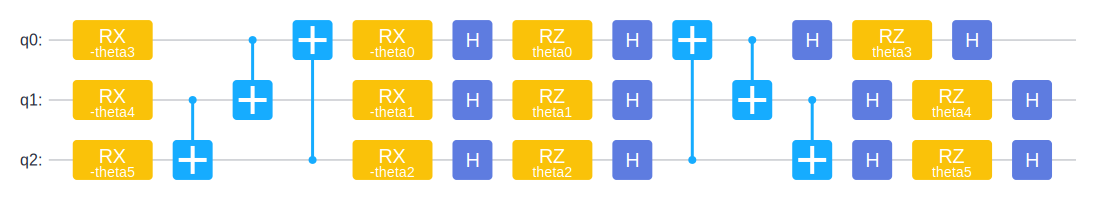

In [18]:
test_circ1 = build_ansatz(3, 1)
test_circ1_inv = dagger(test_circ1)
test_circ2 = compile_circuit(test_circ1)

test_circ_all = test_circ1_inv + test_circ2

test_circ_all.svg()

In [19]:
# draw the testing circuit into a ZX diagram
test_g = draw_graph(test_circ_all)
test_g.print()

==================graph message==================
0 	 [4] 	 red 	 -theta5
1 	 [3] 	 red 	 -theta4
2 	 [5] 	 red 	 -theta3
3 	 [1, 4, 6] 	 green 	 0.0
4 	 [0, 3, 7] 	 red 	 0.0
5 	 [2, 6, 8] 	 green 	 0.0
6 	 [3, 5, 10] 	 red 	 0.0
7 	 [4, 8, 9] 	 green 	 0.0
8 	 [5, 7, 11] 	 red 	 0.0
9 	 [7, 18] 	 red 	 -theta2
10 	 [6, 15] 	 red 	 -theta1
11 	 [8, 12] 	 red 	 -theta0
12 	 [11, 13] 	 yellow 	 0.0
13 	 [12, 14] 	 green 	 theta0
14 	 [13, 22] 	 yellow 	 0.0
15 	 [10, 16] 	 yellow 	 0.0
16 	 [15, 17] 	 green 	 theta1
17 	 [16, 24] 	 yellow 	 0.0
18 	 [9, 19] 	 yellow 	 0.0
19 	 [18, 20] 	 green 	 theta2
20 	 [19, 21] 	 yellow 	 0.0
21 	 [20, 22, 26] 	 green 	 0.0
22 	 [14, 21, 23] 	 red 	 0.0
23 	 [22, 24, 27] 	 green 	 0.0
24 	 [17, 23, 25] 	 red 	 0.0
25 	 [24, 26, 30] 	 green 	 0.0
26 	 [21, 25, 33] 	 red 	 0.0
27 	 [23, 28] 	 yellow 	 0.0
28 	 [27, 29] 	 green 	 theta3
29 	 [28] 	 yellow 	 0.0
30 	 [25, 31] 	 yellow 	 0.0
31 	 [30, 32] 	 green 	 theta4
32 	 [31] 	 yellow 	 0.0
33 	 [

In [20]:
# simplify the testing circuit
print("before simplification:")
test_g.equiv()

simplify(test_g)

print("after simplification:")
test_g.equiv()

before simplification:
Not sure!
after simplification:
Equivalent!


After passing the simplification function test, we can try to simplify the ZX diagram of the complete circuit. The result shows that the two circuits before and after compilation are equivalent.

In [21]:
# simplify the complete circuit
print("before simplification:")
g.equiv()

simplify(g)

print("after simplification:")
g.equiv()

before simplification:
Not sure!


after simplification:
Equivalent!


## Step 4

If ZX Calculus not sure then verify by instantiating the parameter.

The ZX calculus cannot directly give the result of the equivalent circuits. In this case, we need to instantiate the parameters in the circuits to determine whether the two circuits after instantiation are equivalent.

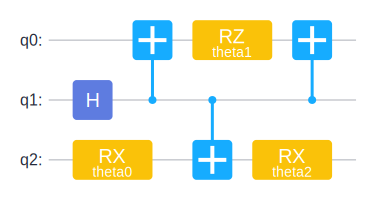

In [22]:
# counterexample
neq_circ1 = Circuit()
neq_circ1 += H.on(1)
neq_circ1 += RX(f'theta{0}').on(2)
neq_circ1 += CNOT.on(0, 1)
neq_circ1 += RZ(f'theta{1}').on(0)
neq_circ1 += CNOT.on(2, 1)
neq_circ1 += CNOT.on(0, 1)
neq_circ1 += RX(f'theta{2}').on(2)

neq_circ1.svg()

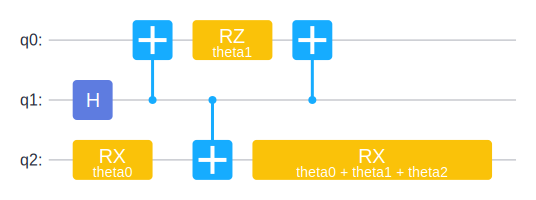

In [23]:
neq_circ2 = Circuit()
neq_circ2 += H.on(1)
neq_circ2 += RX(f'theta{0}').on(2)
neq_circ2 += CNOT.on(0, 1)
neq_circ2 += RZ(f'theta{1}').on(0)
neq_circ2 += CNOT.on(2, 1)
neq_circ2 += CNOT.on(0, 1)
neq_circ2 += RX({f'theta{0}': 1, f'theta{1}': 1, f'theta{2}': 1}).on(2)

neq_circ2.svg()

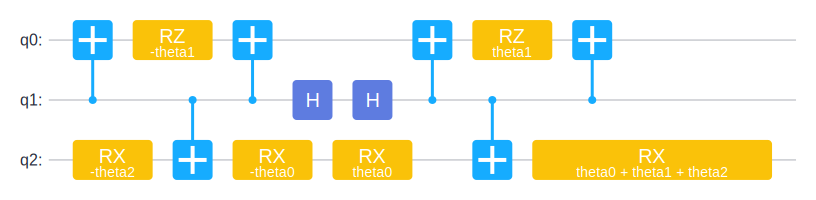

In [24]:
neq_circ1_inv = dagger(neq_circ1)
neq_circ_all = neq_circ1_inv + neq_circ2    # construct the complete circuit of the counterexample
neq_circ_all.svg()

In [25]:
# draw the counterexample into ZX diagram and simplify it
neq_g = draw_graph(neq_circ_all)
print("before simplification:")
neq_g.equiv()

simplify(neq_g)

print("after simplification:")
neq_g.equiv()

before simplification:
Not sure!
after simplification:
Not sure!


In this case, after simplification, there are still undeleted vertices in the ZX diagram. So the ZX calculus cannot determine its equivalence and needs to be verified by instantiating parameters.

The instantiation has two steps:

First, directly compare whether the matrices of the two circuits are equivalent after instantiation according to the map function, and stop if not.

Second, if the instantiation according to the map function does not get the result, randomly instantiate the parameters, and then directly compare whether the matrices of the two circuits after instantiation are equivalent. If unequivalent, the two circuits are unequivalent, otherwise equivalent.

In [26]:
# instantiation according to the map function
def map_para(n, r):
    para = {}
    for i in range(n):
        para[f'theta{i}'] = (2*np.pi/((i+1)*r)-np.pi)
    return para


# randomly instantiate the parameters
def random_para(n):
    para = {}
    for i in range(n):
        para[f'theta{i}'] = (np.random.uniform(np.pi, -np.pi))
    return para

In [27]:
# verify by instantiating parameters
def verify_by_para(circ1, circ2, r):
    # there are n parameters in the circuit
    n = len(list(set(circ1.params_name+circ2.params_name)))
    flag = True    # whether the previous r-1 round has a result
    for i in range(r-1):    # instantiation according to the map function
        para = map_para(n, i+1)
        # whether the matrices of the two circuits are equivalent
        if np.array_equal(circ1.matrix(para), circ2.matrix(para)):
            continue
        else:
            print('Not equivalent!')
            flag = False    # get a result
            break

    if flag:    # randomly instantiate the parameters
        para = random_para(n)
        if np.array_equal(circ1.matrix(para), circ2.matrix(para)):
            print('Equivalent!')
        else:
            print('Not equivalent!')

Verify the equivalence of the two counterexample circuits by instantiation.

In [28]:
verify_by_para(neq_circ1, neq_circ2, 5)

Not equivalent!


## Final step: merge the above process into a complete function

In [29]:
def ZXcalculus(circ1, circ2):
    circ1_inv = dagger(circ1)    # reverse the initial circuit
    circ = circ1_inv + circ2    # construct the complete circuit
    g = draw_graph(circ)    # draw the complete circuit into ZX diagram
    print("before simplification:")
    g.equiv()
    simplify(g)    # simplify by the rules
    print("after simplification:")
    if not g.vertices:    # get a result by ZX calculus
        g.equiv()
    else:    # need to verify by instantiation
        g.equiv()
        print("verify by instantiation:")
        verify_by_para(circ1, circ2, 5)

In [30]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'scipy', 'numpy')

Software,Version
mindquantum,0.9.11
scipy,1.9.3
numpy,1.23.5
System,Info
Python,3.8.17
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Tue Jan 2 17:34:07 2024
